<a href="https://colab.research.google.com/github/aasthagoyal46/HousingPricePrediction/blob/master/HousingPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [138]:
train_url = 'https://raw.githubusercontent.com/aasthagoyal46/HousingPricePrediction/master/house-prices-advanced-regression-techniques/train.csv'
test_url = 'https://raw.githubusercontent.com/aasthagoyal46/HousingPricePrediction/master/house-prices-advanced-regression-techniques/test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [0]:
all_data = pd.concat((train.iloc[:,1:-1], test.iloc[:,1:]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2091a816a0>,
      dtype=object)

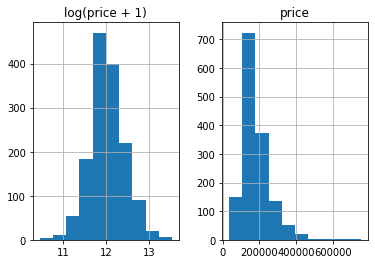

In [140]:
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [0]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [0]:
num_data = all_data[numeric_feats]
num_data = (num_data-num_data.mean())/num_data.std()
all_data[numeric_feats] = num_data

In [144]:
all_data = pd.get_dummies(all_data, dummy_na=True)
print(all_data.shape)

(2919, 331)


In [0]:
all_data = all_data.fillna(all_data.mean())

In [0]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [0]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from google.colab import files

In [0]:
def rmse_cv(model, x, y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [170]:
a = 0.1
model_ridge = Ridge(alpha = a)
rmse = rmse_cv(model_ridge, X_train, y).mean()
print(rmse)

0.13782000341240913


In [0]:
model_ridge.fit(X_train, y)

predictions = np.expm1(model_ridge.predict(X_test))
result = pd.DataFrame({"Id": test["Id"], 'SalePrice':predictions})

result.to_csv('result01.csv', index=False)

In [0]:
# files.download('result01.csv')

Ridge Regression with alpha 0.1: <br>
Test RMSE - 0.13029

In [152]:
from sklearn.linear_model import Lasso

rmse_cv(Lasso(alpha=0.1), X_train, y).mean()

0.21589772487941042

Text(0, 0.5, 'rmse')

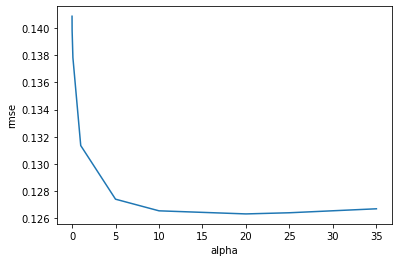

In [174]:
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 20, 25, 35]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y).mean() 
            for alpha in alphas]

plt.plot(alphas, cv_ridge)
plt.xlabel("alpha")
plt.ylabel("rmse")

Text(0, 0.5, 'rmse')

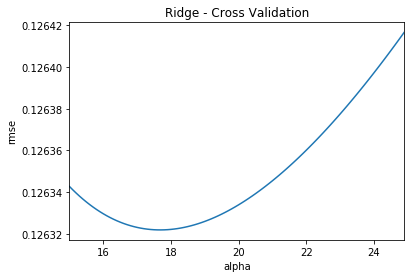

In [176]:
alphas = np.arange(15.0, 25.0, 0.1)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge - Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [177]:
ridgeAlpha = cv_ridge[cv_ridge == min(cv_ridge)].index[0]
print(ridgeAlpha, min(cv_ridge))

ridgeOpt = Ridge(alpha = ridgeAlpha)

ridgeOpt.fit(X_train, y)

predictions = np.expm1(ridgeOpt.predict(X_test))
resultRidge = pd.DataFrame({"Id": test["Id"], 'SalePrice':predictions})

resultRidge.to_csv('result02.csv', index=False)

17.69999999999999 0.12632184937979038


In [0]:
# files.download('result02.csv')

Optimum Ridge Submission: <br>
Test Error : 0.11981

In [0]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
cv_lasso = [rmse_cv(Lasso(alpha = alpha).fit(X_train, y), X_train, y).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

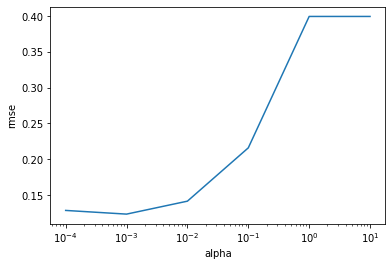

In [158]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
plt.semilogx(alphas, cv_lasso)
plt.xlabel("alpha")
plt.ylabel("rmse")

In [159]:
lassoAlpha = cv_lasso[cv_lasso == min(cv_lasso)].index[0]
print(lassoAlpha, min(cv_lasso))

lassoOpt = Lasso(alpha = lassoAlpha)

lassoOpt.fit(X_train, y)

predictions = np.expm1(lassoOpt.predict(X_test))
resultLasso = pd.DataFrame({"Id": test["Id"], 'SalePrice':predictions})

resultLasso.to_csv('result03.csv', index=False)

0.001 0.12347484470905838


In [0]:
# files.download('result03.csv')

Optimum Lasso Submission: <br>
Test Error: 0.12195

In [161]:
coef = [Lasso(alpha = alpha).fit(X_train, y).coef_ for alpha in alphas]
coef = [sum(c!=0) for c in coef]
print(coef)

[197, 77, 18, 6, 0, 0]


Text(0, 0.5, 'non-zero coef')

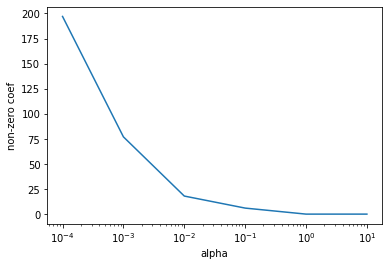

In [162]:
plt.semilogx(alphas, coef)
plt.xlabel("alpha")
plt.ylabel("non-zero coef")

Text(0, 0.5, 'rmse')

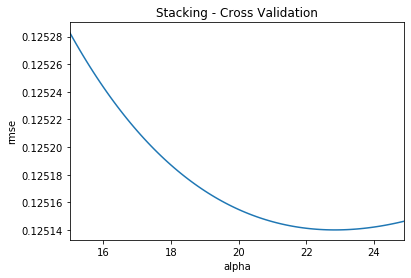

In [163]:
X_train1 = X_train.copy()
X_train1["Ridge"] = ridgeOpt.predict(X_train)
X_train1["Lasso"] = lassoOpt.predict(X_train)

alphas = np.arange(15.0, 25.0, 0.1)
# alphas = [0.001, 0.01, 0.1, 1, 5, 10, 20, 25, 35]
cv_stacking = [rmse_cv(Ridge(alpha = alpha), X_train1, y).mean() 
            for alpha in alphas]

cv_stacking = pd.Series(cv_stacking, index = alphas)
cv_stacking.plot(title = "Stacking - Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [164]:
stackingAlpha = cv_stacking[cv_stacking == min(cv_stacking)].index[0]
print(stackingAlpha, min(cv_stacking))

22.799999999999972 0.12514002338545582


In [0]:
stackingOpt = Ridge(alpha = stackingAlpha)

stackingOpt.fit(X_train1, y)

X_test1 = X_test.copy()
X_test1["Ridge"] = ridgeOpt.predict(X_test)
X_test1["Lasso"] = lassoOpt.predict(X_test)

predictions = np.expm1(stackingOpt.predict(X_test1))
resultStacking = pd.DataFrame({"Id": test["Id"], 'SalePrice':predictions})

resultStacking.to_csv('result04.csv', index=False)


In [0]:
files.download('result04.csv')

Stacking: <br>
Test Error: 0.11975

In [0]:
# files.download('result04.csv')